In [ ]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(__file__)))
from utils.utils import set_up_altair, moving_averages, read_json_to_df, format_time_columns,aggregate_by_year_month, filter_by_year
from statsmodels.tsa.seasonal import STL as STL
import pandas as pd
import altair as alt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.tsa.stattools as ts

PATH = "../../data/all_incidents.json"
data = read_json_to_df(PATH)
data = format_time_columns(data)
incident_count = aggregate_by_year_month(data)
incident_count.set_index('dateTime', inplace=True)


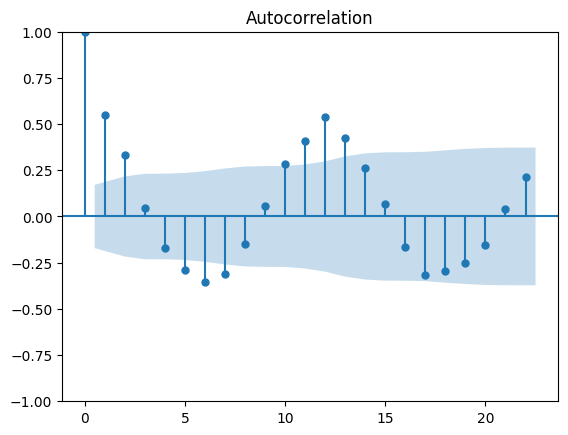

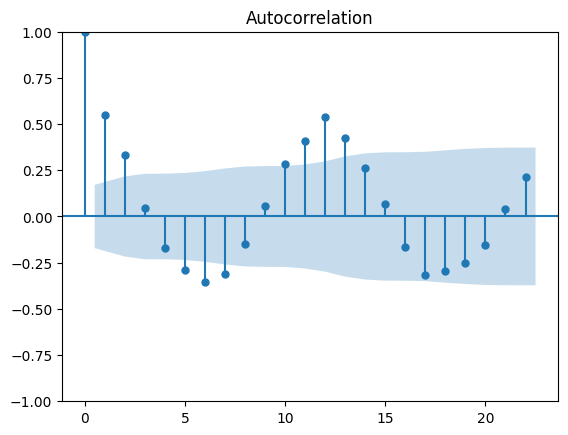

In [2]:
sm.tsa.graphics.plot_acf(incident_count['Incident'])

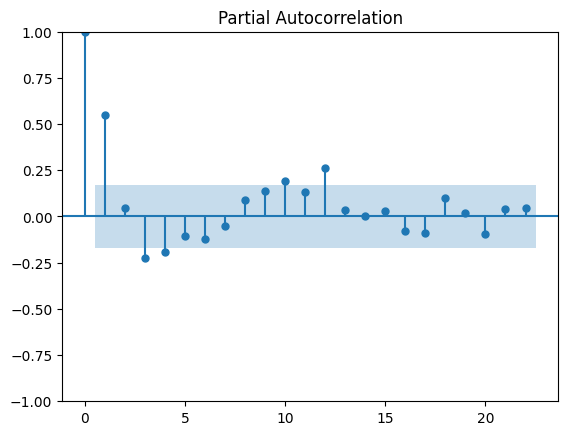

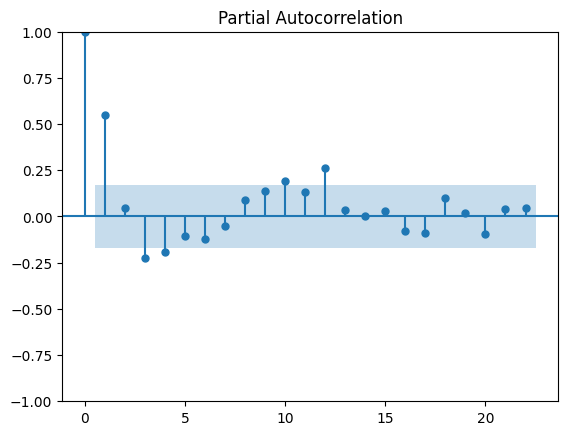

In [12]:
sm.tsa.graphics.plot_pacf(incident_count['Incident'])

In [ ]:
ts.adfuller(incident_count['Incident'])

(np.float64(-1.4865444553965372),
 np.float64(0.5401567933397874),
 11,
 119,
 {'1%': np.float64(-3.4865346059036564),
  '5%': np.float64(-2.8861509858476264),
  '10%': np.float64(-2.579896092790057)},
 np.float64(716.9525896738346))

In [9]:
#differencing
incident_count['lag_12'] = incident_count['Incident'].shift(12)
incident_count['seasonal_diff'] = incident_count['Incident'] - incident_count['lag_12']


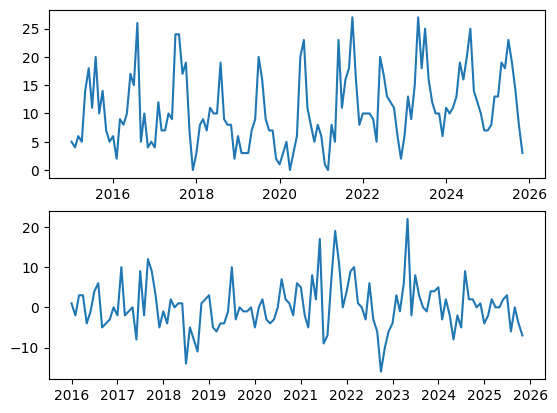

In [10]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(incident_count['Incident'], label = 'original')
axes[1].plot(incident_count['seasonal_diff'], label = 'seasonal diff')

In [13]:
import pmdarima as pm

In [15]:
stepwise_model = pm.auto_arima(incident_count.Incident, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=766.520, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=743.415, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=764.777, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=761.442, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=733.571, Time=0.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=741.784, Time=0.43 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=734.590, Time=0.81 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=734.514, Time=0.81 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=735.722, Time=0.57 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=735.971, Time=1.38 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=732.35

In [16]:
selected_model = sm.tsa.statespace.SARIMAX(incident_count['Incident'], 
                                order=(1,0,0), 
                                seasonal_order=(2,1,0,12), 
                                trend='c').fit()

c:\Users\Chua Shi Min\Documents\mountain_rescue\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Chua Shi Min\Documents\mountain_rescue\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


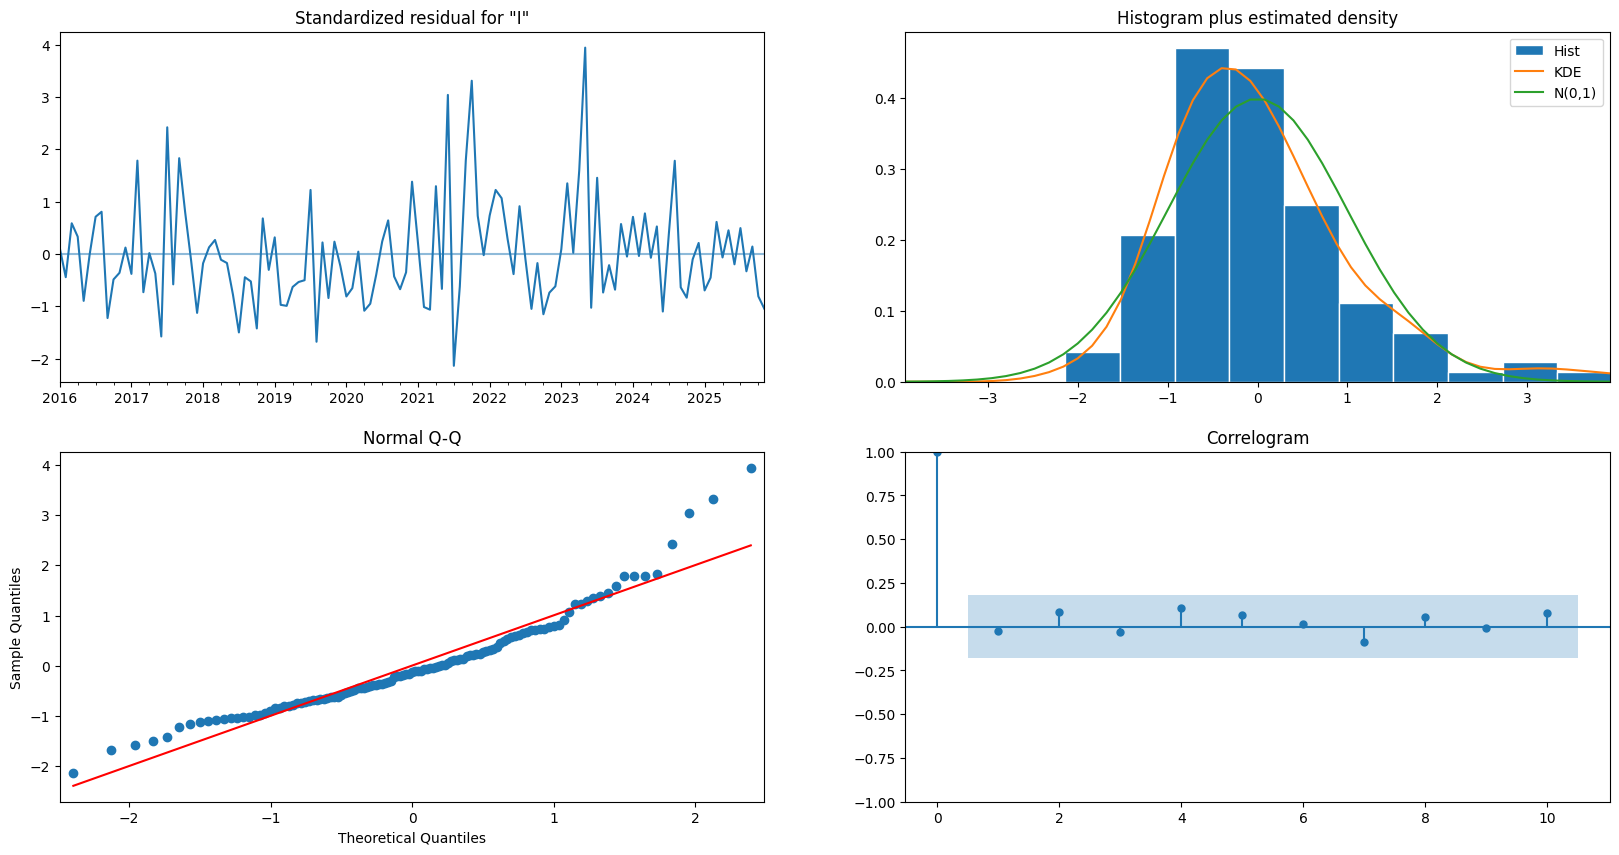

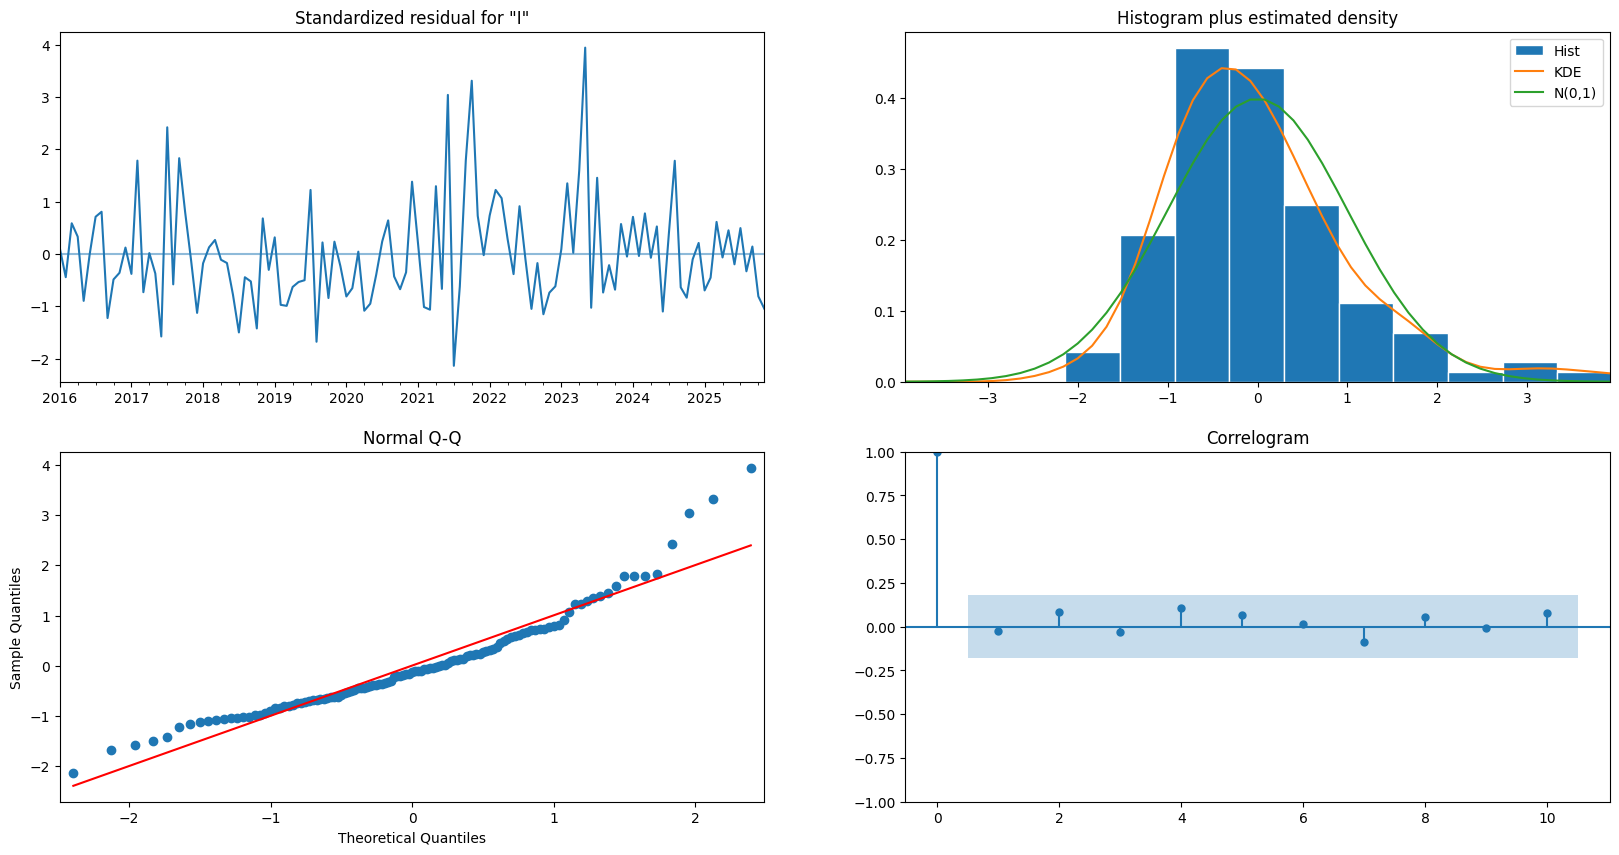

In [18]:
selected_model.plot_diagnostics(figsize=(20,10))

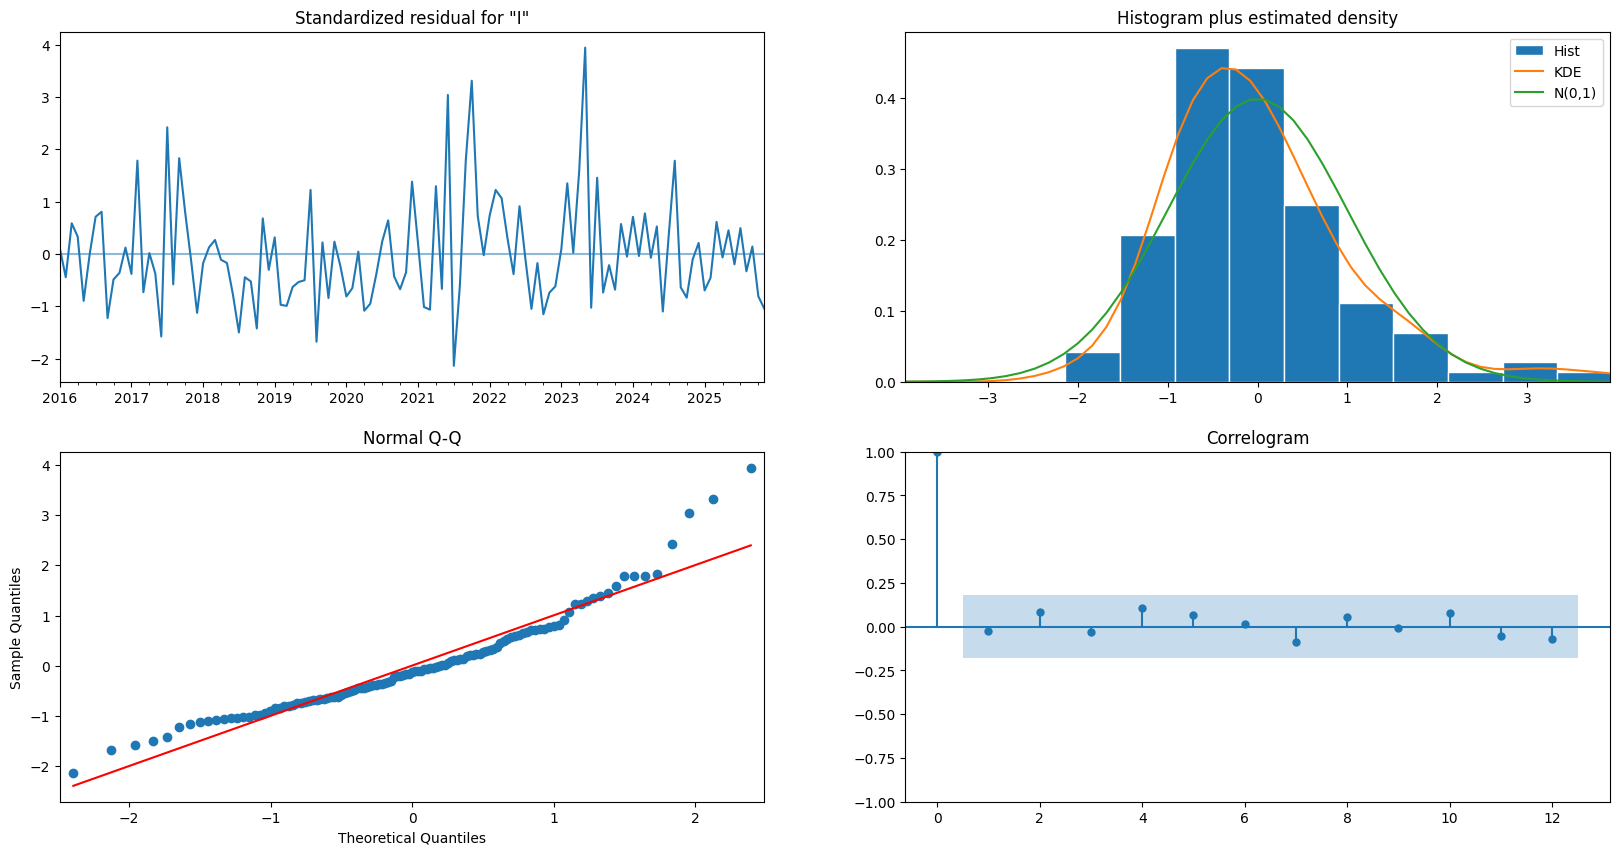

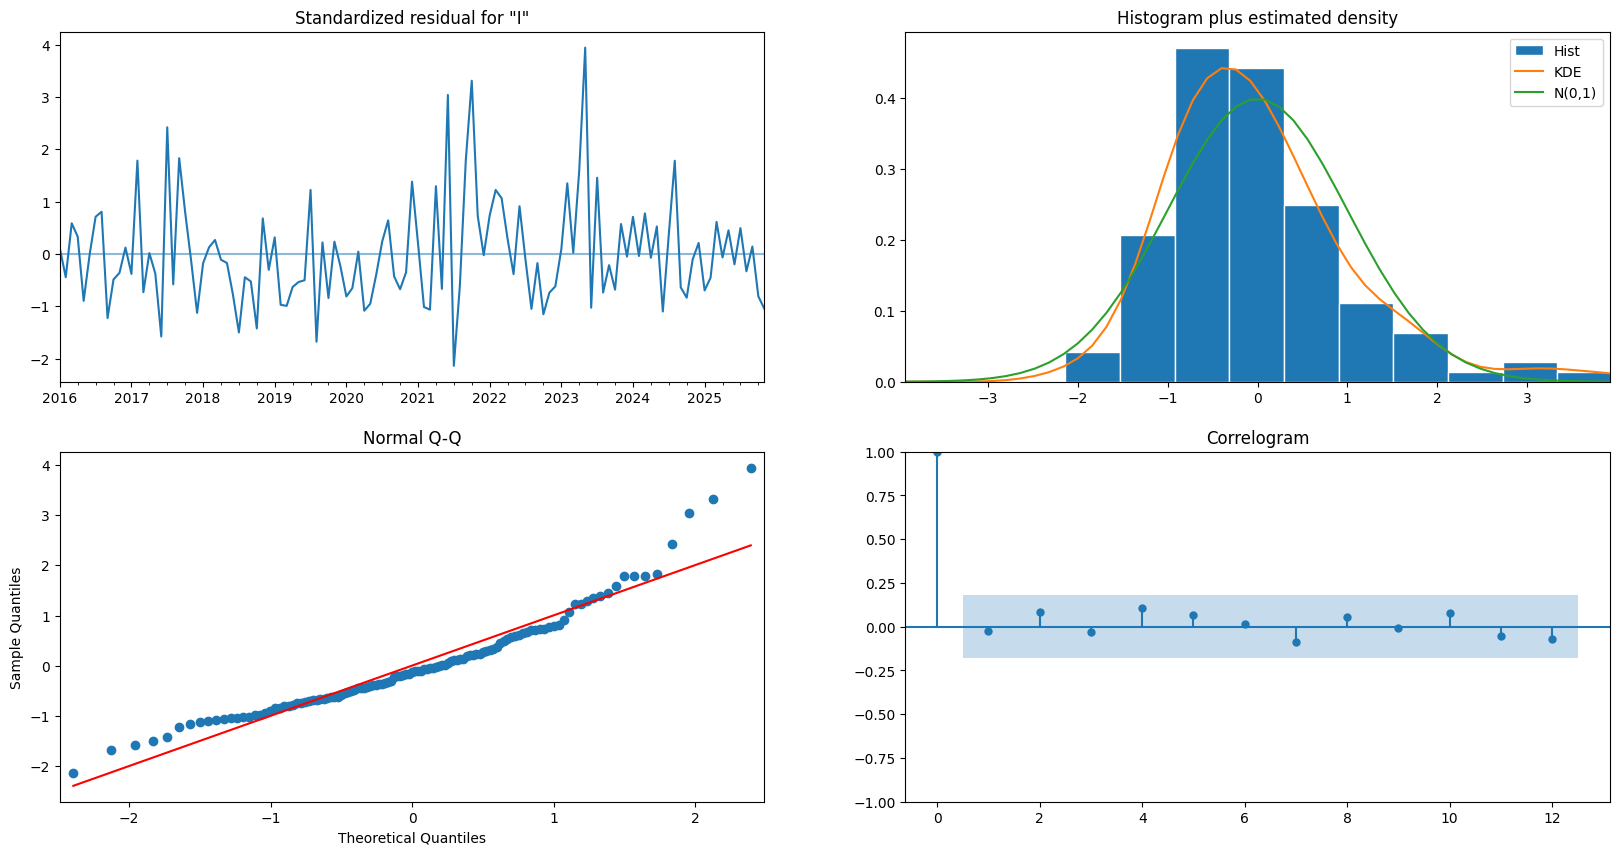

In [19]:
selected_model.plot_diagnostics(lags = 12, figsize=(20,10))

In [20]:
selected_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Incident   No. Observations:                  131
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -361.785
Date:                            Wed, 21 Jan 2026   AIC                            733.571
Time:                                    17:55:38   BIC                            747.467
Sample:                                01-01-2015   HQIC                           739.213
                                     - 11-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4337      0.617      0.703      0.482      -0.776       1.643
ar.L1          0.2910      0.080      3.655      0.000       0.135       0.447
ar.S.L12      -0.5211      0.109     -4.783      0.000      -0.735      -0.308
ar.S.L24      -0.3231      0.107     -3.008      0.003      -0.534      -0.113
sigma2        24.5953      2.926      8.406      0.000      18.860      30.330
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                51.00
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             1.16
Prob(H) (two-sided):                  0.50   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

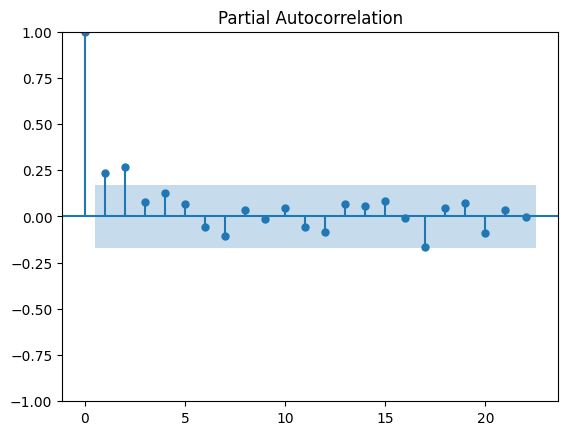

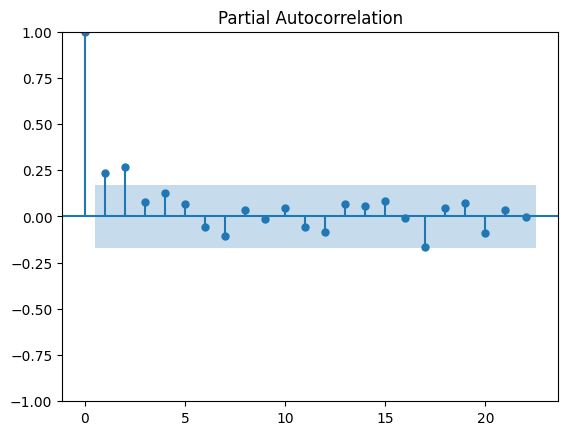

In [21]:
sm.tsa.graphics.plot_pacf(selected_model.resid)

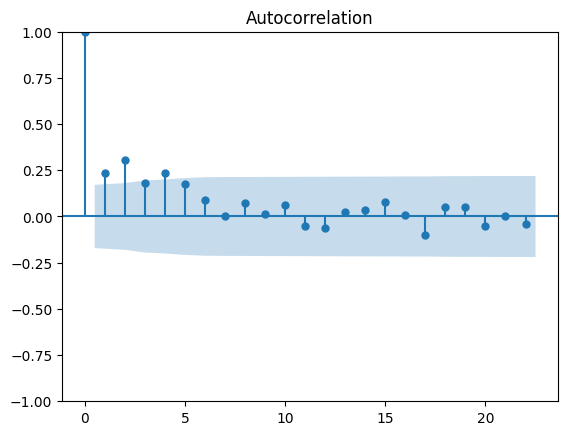

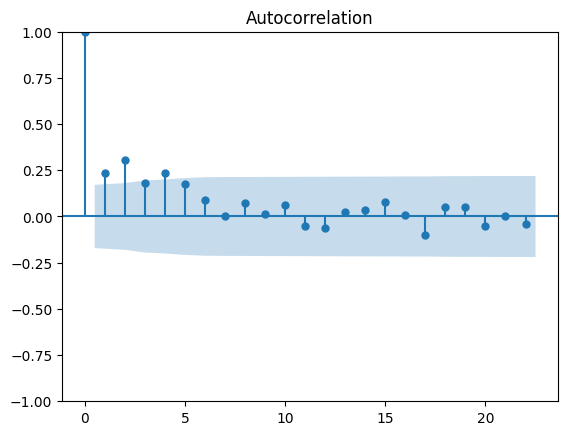

In [22]:
sm.tsa.graphics.plot_acf(selected_model.resid)

(array([ 3., 16., 33., 32., 19., 13.,  6.,  2.,  4.,  3.]),
 array([-10.60039844,  -7.5735445 ,  -4.54669056,  -1.51983662,
          1.50701732,   4.53387127,   7.56072521,  10.58757915,
         13.61443309,  16.64128703,  19.66814098]),
 <BarContainer object of 10 artists>)

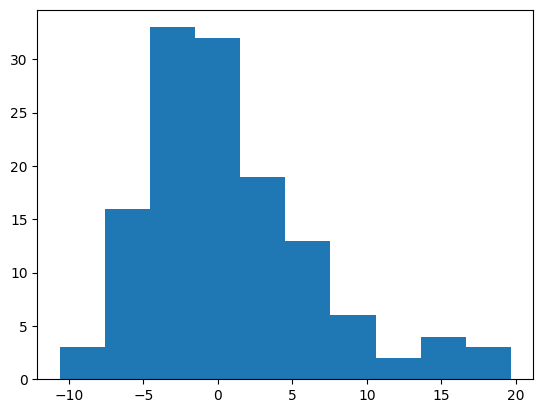

In [24]:
plt.hist(selected_model.resid)

In [25]:
prediction = selected_model.predict(start = 132, end = 144)

In [26]:
incident_count['forecast']  = prediction


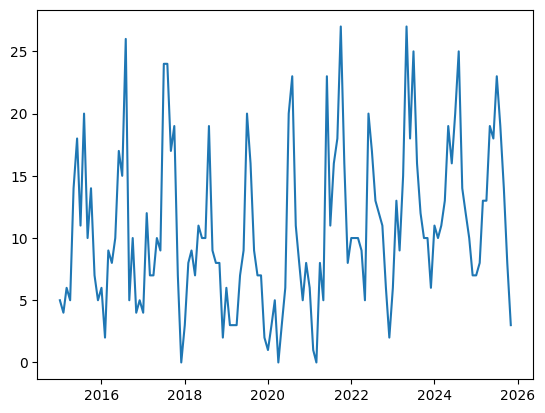

In [29]:
plt.plot(incident_count.Incident)
plt.plot(incident_count.forecast, color='green')